# Notebook 12 a) Aspect Prediction with Machine Learning Models

This notebook investigates predictive models for the aspects part of the review data based on the extracted nouns using ML models. The output is therefore MULTICLASS.

* Section 1 - Import libraries and dataset
* Section 2 - Pre-processing
* Section 3 - Run models
* Section 4 - Prediction on validation set

Dataset:
* combinedaspectcheck.xlsx

# Section 1: Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score,precision_score, recall_score, f1_score
import joblib
import pickle
import warnings

In [2]:
df_accom = pd.read_excel('combinedaspectcheck.xlsx',sheet_name = 'CLEANEDACCOM')
df_food = pd.read_excel("combinedaspectcheck.xlsx",sheet_name = "CLEANEDFOOD")
df_attract = pd.read_excel("combinedaspectcheck.xlsx", sheet_name = "CLEANEDATTRACT")

In [3]:
df_accom.head()

,OrigInd,Category,Cleaned,Noun Phrases,Nouns,Aspect,Sentiment
0,2030,Accommodation,main complaint room made u feel ill,main complaint room,complaint room,Room,-0.2960
1,10751,Accommodation,weekend away staff great room clean shower goo...,great room,room,Room,0.6249
2,11247,Accommodation,great room breakfast fabulous central location,great room breakfast fabulous,room breakfast,Room,0.8176
3,21902,Accommodation,shower great size well toiletry clean towel pr...,clean towel,towel,Room,0.4019
4,22835,Accommodation,great bed breakfast stayed week encore guest h...,lovely clean room facility,room facility,Room,0.7579


# Section 2: Pre-processing

In [4]:
# Drop column
df_accom.drop(["Category"],axis = 1, inplace = True)
df_food.drop(["Category"],axis = 1,inplace = True)
df_attract.drop(["Category"],axis = 1,inplace = True)

In [5]:
# Set to title case as some categories are multiples
df_accom["Aspect"] = df_accom["Aspect"].apply(lambda x: x.title())

In [6]:
df_accom["Aspect"].value_counts()

Staff            350
Hotel            350
Food             350
Room             350
Entertainment    350
Value            250
Location         220
Name: Aspect, dtype: int64

In [7]:
df_food["Aspect"].value_counts()

Staff&Service    350
Value            350
Meal Exp         350
Menu Choice      350
Visit Exp        350
Food Quality     350
Name: Aspect, dtype: int64

In [8]:
df_attract["Aspect"].value_counts()

Nature           300
Activities       300
Amenities        300
VisitExp&Gen     250
Staff&Service    200
Value            150
History          150
Name: Aspect, dtype: int64

In [9]:
# Function to specify X and y
def XY(df):
    X = df["Nouns"]
    y = df["Aspect"]

    return X,y

In [10]:
# Apply function and print shape
X_accom,y_accom = XY(df_accom)
X_food,y_food = XY(df_food)
X_attract,y_attract = XY(df_attract)

print(X_accom.shape,y_accom.shape)
print(X_food.shape,y_food.shape)
print(X_attract.shape,y_attract.shape)


(2220,) (2220,)
(2100,) (2100,)
(1650,) (1650,)


In [56]:
# Train, validation split
def train_test(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.20, shuffle = True)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test,test_size=0.50, shuffle = True)
    return X_train,X_val, X_test, y_train,y_val,y_test

In [57]:
# Run function for each category
X_train_accom,X_val_accom,X_test_accom,y_train_accom,y_val_accom,y_test_accom = train_test(X_accom,y_accom)
X_train_food,X_val_food,X_test_food,y_train_food,y_val_food,y_test_food = train_test(X_food,y_food)
X_train_attract,X_val_attract,X_test_attract,y_train_attract,y_val_attract,y_test_attract = train_test(X_attract,y_attract)

In [58]:
# Shape of training, validation and test sets for each category
print(X_train_accom.shape, X_val_accom.shape,X_test_accom.shape, y_train_accom.shape, y_val_accom.shape, y_test_accom.shape)
print(X_train_food.shape, X_val_food.shape,X_test_food.shape, y_train_food.shape, y_val_food.shape, y_test_food.shape)
print(X_train_attract.shape, X_val_attract.shape,X_test_attract.shape, y_train_attract.shape, y_val_attract.shape, y_test_attract.shape)

(1776,) (222,) (222,) (1776,) (222,) (222,)
(1680,) (210,) (210,) (1680,) (210,) (210,)
(1320,) (165,) (165,) (1320,) (165,) (165,)


In [59]:
y_train_accom.value_counts()

Staff            280
Hotel            280
Food             280
Room             280
Entertainment    280
Value            200
Location         176
Name: Aspect, dtype: int64

In [163]:
# TFIDF vectorizer function
def vec(X_train, X_val, X_test):
    vect = TfidfVectorizer(use_idf = True, max_df = 1.0, min_df = 1, stop_words = "english", 
                           ngram_range = (1,1),smooth_idf = True, norm = 'l2')
    vect.fit(X_train)
    X_train_tfidf = vect.transform(X_train)
    X_val_tfidf = vect.transform(X_val)
    X_test_tfidf = vect.transform(X_test)
    return vect, X_train_tfidf, X_val_tfidf, X_test_tfidf

In [164]:
# Run function
accom_vect,X_train_accom_tfidf, X_val_accom_tfidf, X_test_accom_tfidf = vec(X_train_accom, X_val_accom,X_test_accom)
food_vect, X_train_food_tfidf, X_val_food_tfidf, X_test_food_tfidf = vec(X_train_food, X_val_food, X_test_food)
attract_vect,X_train_attract_tfidf, X_val_attract_tfidf, X_test_attract_tfidf = vec(X_train_attract, X_val_attract,X_test_attract)

In [62]:
# Function to save tokenizer objects
def save_tok(name,file):
    with open(name, 'wb') as handle:
        pickle.dump(file, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [177]:
save_tok('accom_tok.pickle',accom_vect)
save_tok('food_tok.pickle',food_vect)
save_tok('attract_tok.pickle',attract_vect)

In [64]:
# Function to encode y values as integer labels (necessary for stratified cross validation as one-hot encoded doesn't work)
def lab(y_train, y_val, y_test):
    le = preprocessing.LabelEncoder()
    y_train_l = le.fit_transform(y_train)
    y_val_l = le.transform(y_val)
    y_test_l = le.transform(y_test)
    return y_train_l, y_val_l, y_test_l

In [65]:
# Apply functions
y_train_accom_l, y_val_accom_l, y_test_accom_l = lab(y_train_accom, y_val_accom, y_test_accom)
y_train_food_l, y_val_food_l, y_test_food_l = lab(y_train_food, y_val_food, y_test_food)
y_train_attract_l, y_val_attract_l, y_test_attract_l = lab(y_train_attract, y_val_attract, y_test_attract)

In [66]:
X_train_accom_tfidf

<1776x770 sparse matrix of type '<class 'numpy.float64'>'
	with 3574 stored elements in Compressed Sparse Row format>

In [67]:
# Stratified K Fold
def strat(model, X_train,y_train,vector):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cv_results = cross_val_score(model, X_train,y_train, cv=kfold)
    mean = cv_results.mean()
    df = pd.DataFrame({vector:mean},index = [0])
    return df

# Section 3: Run models

In [68]:
# Define models - balanced as some imbalance in classes
clf1 = MultinomialNB()
clf2 = LogisticRegression(multi_class = 'multinomial', class_weight = "balanced")
clf3 = RandomForestClassifier(class_weight = "balanced")
clf4 = SVC(decision_function_shape='ovr',class_weight = "balanced", probability = True)

In [69]:
# Define models and run cross-validation on the training set data only
ac1 = strat(clf1, X_train_accom_tfidf, y_train_accom_l,"NB")
f1 = strat(clf1, X_train_food_tfidf, y_train_food_l,"NB")
t1 = strat(clf1, X_train_attract_tfidf, y_train_attract_l,"NB")

ac2 = strat(clf2, X_train_accom_tfidf, y_train_accom_l,"LR")
f2 = strat(clf2, X_train_food_tfidf, y_train_food_l,"LR")
t2 = strat(clf2, X_train_attract_tfidf, y_train_attract_l,"LR")

ac3 = strat(clf3, X_train_accom_tfidf, y_train_accom_l,"RF")
f3 = strat(clf3, X_train_food_tfidf, y_train_food_l,"RF")
t3 = strat(clf3, X_train_attract_tfidf, y_train_attract_l,"RF")

ac4 = strat(clf4, X_train_accom_tfidf, y_train_accom_l,"SVM")
f4 = strat(clf4, X_train_food_tfidf, y_train_food_l,"SVM")
t4 = strat(clf4, X_train_attract_tfidf, y_train_attract_l,"SVM")

In [70]:
# Training accuracies all models
models = ["Accom","Food","Attract"]
a = pd.concat([ac1,ac2,ac3,ac4],axis = 1)
b = pd.concat([f1,f2,f3,f4],axis = 1)
c = pd.concat([t1,t2,t3,t4],axis = 1)
all_models = pd.concat([a,b,c],axis = 0)
all_models.set_index([models],inplace = True)
all_models

,NB,LR,RF,SVM
Accom,0.913315,0.914994,0.916092,0.907103
Food,0.927381,0.954167,0.963690,0.944643
Attract,0.811364,0.844697,0.801515,0.809848


# Section 4: Prediction on validation set

In [71]:
# Function to produce predictions and metrics

def prediction(model,X_train,y_train,X_val,y_val,labels):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    target_probs = model.predict_proba(X_val)
    #y_class = np.argmax(y_pred, axis = 0)
    print(classification_report(y_val, y_pred))
    conf_mat = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels = labels, yticklabels = labels,cmap = plt.cm.Blues)
    ax.set_ylabel('Actual',labelpad = 10)
    ax.set_xlabel('Predicted', labelpad = 13)
    
    # Test Set Metrics - using weighted average as there is label imbalance. ROCAUC also using one versus rest to
    # calculate the average score across classes
    accuracy = accuracy_score(y_val, y_pred)
    rocauc = roc_auc_score(y_val,target_probs, average = "weighted", multi_class='ovr')
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    prediction.results = pd.DataFrame({"Accuracy":accuracy, "Precision":precision, "Recall":recall,
                                    "F1":f1,"ROCAUC":rocauc}, index = [0]
                                  )
        
    plt.show()

In [72]:
# Define labels for confusion matrices
labels_accom = ["Entertainment","Food","Hotel","Location","Room","Staff","Value"]
labels_food = ["Food Quality","Meal Exp","Menu Choice","Staff","Value","Visit Exp"]
labels_attract = ["Activities","Amenities","History","Nature","Staff","Value","VisitGen",]

## Accommodation

### Multinomial NB

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        35
           1       0.92      0.94      0.93        35
           2       0.94      0.94      0.94        35
           3       1.00      0.91      0.95        22
           4       0.94      0.91      0.93        35
           5       0.92      0.94      0.93        35
           6       1.00      0.92      0.96        25

    accuracy                           0.92       222
   macro avg       0.93      0.92      0.93       222
weighted avg       0.93      0.92      0.92       222



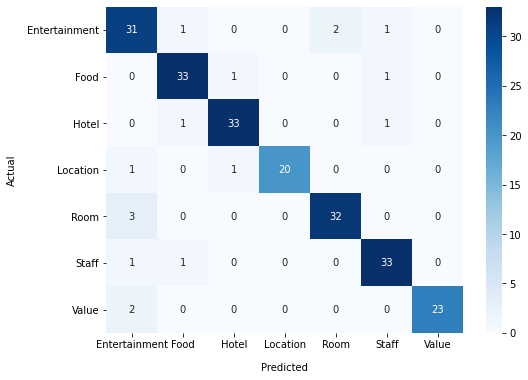

In [73]:
prediction(clf1,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [74]:
modnb1 = prediction.results
modnb1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.923423,0.926399,0.923423,0.924193,0.992637


### Logistic Regression

              precision    recall  f1-score   support

           0       0.71      0.97      0.82        35
           1       1.00      0.97      0.99        35
           2       0.97      0.94      0.96        35
           3       0.95      0.91      0.93        22
           4       0.94      0.89      0.91        35
           5       1.00      0.89      0.94        35
           6       1.00      0.84      0.91        25

    accuracy                           0.92       222
   macro avg       0.94      0.92      0.92       222
weighted avg       0.94      0.92      0.92       222



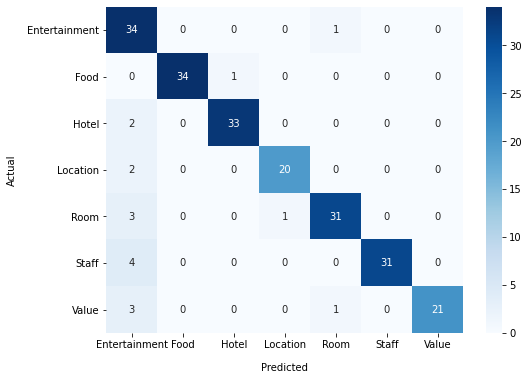

In [75]:
prediction(clf2,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [76]:
modlr1 = prediction.results
modlr1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.918919,0.935106,0.918919,0.922196,0.995721


### Random Forest

              precision    recall  f1-score   support

           0       0.67      0.94      0.79        35
           1       1.00      0.97      0.99        35
           2       1.00      0.94      0.97        35
           3       1.00      0.91      0.95        22
           4       0.94      0.89      0.91        35
           5       1.00      0.89      0.94        35
           6       1.00      0.88      0.94        25

    accuracy                           0.92       222
   macro avg       0.94      0.92      0.93       222
weighted avg       0.94      0.92      0.92       222



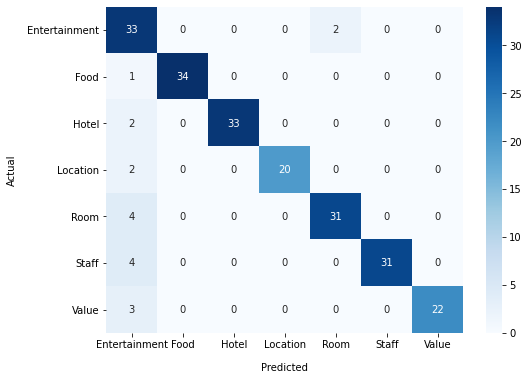

In [77]:
prediction(clf3,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [78]:
modrf1 = prediction.results
modrf1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.918919,0.938965,0.918919,0.923921,0.979215


### SVM

              precision    recall  f1-score   support

           0       0.69      0.94      0.80        35
           1       0.97      0.91      0.94        35
           2       0.94      0.94      0.94        35
           3       0.90      0.86      0.88        22
           4       0.94      0.86      0.90        35
           5       0.97      0.86      0.91        35
           6       1.00      0.88      0.94        25

    accuracy                           0.90       222
   macro avg       0.92      0.89      0.90       222
weighted avg       0.91      0.90      0.90       222



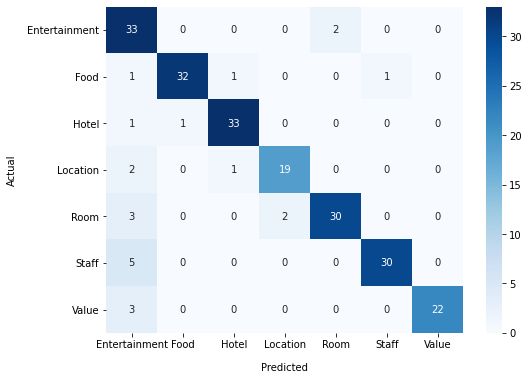

In [79]:
prediction(clf4,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [80]:
modsvm1 = prediction.results
modsvm1

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.896396,0.912568,0.896396,0.89991,0.986667


## Food

### Multinomial NB

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        35
           1       0.93      0.74      0.83        35
           2       0.87      0.97      0.92        35
           3       0.97      0.94      0.96        35
           4       0.97      1.00      0.99        35
           5       0.89      0.97      0.93        35

    accuracy                           0.92       210
   macro avg       0.93      0.92      0.92       210
weighted avg       0.93      0.92      0.92       210



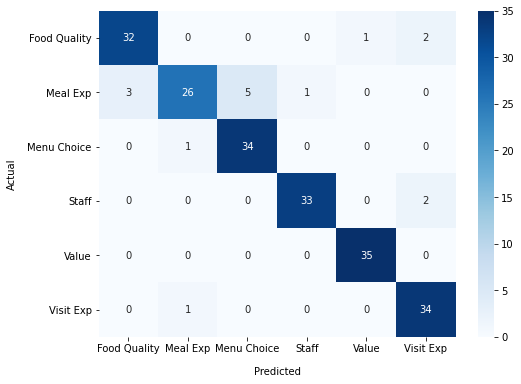

In [81]:
prediction(clf1,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [82]:
modnb2 = prediction.results
modnb2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.92381,0.925367,0.92381,0.922091,0.993551


### Logistic Regression

              precision    recall  f1-score   support

           0       0.91      0.89      0.90        35
           1       0.80      0.94      0.87        35
           2       0.97      0.94      0.96        35
           3       1.00      1.00      1.00        35
           4       1.00      0.94      0.97        35
           5       1.00      0.94      0.97        35

    accuracy                           0.94       210
   macro avg       0.95      0.94      0.94       210
weighted avg       0.95      0.94      0.94       210



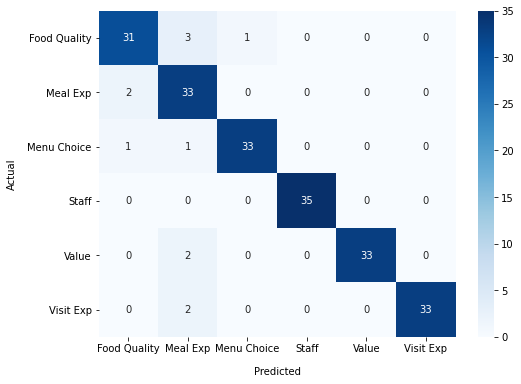

In [83]:
prediction(clf2,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [84]:
modlr2 = prediction.results
modlr2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.942857,0.947872,0.942857,0.944112,0.996354


### Random Forest

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        35
           1       0.85      1.00      0.92        35
           2       0.97      0.97      0.97        35
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00        35
           5       1.00      0.89      0.94        35

    accuracy                           0.96       210
   macro avg       0.97      0.96      0.96       210
weighted avg       0.97      0.96      0.96       210



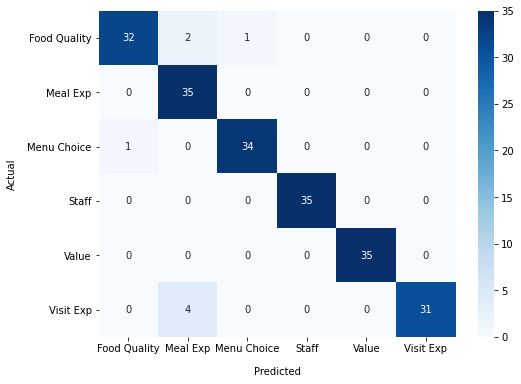

In [85]:
prediction(clf3,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [86]:
modrf2 = prediction.results
modrf2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.961905,0.965797,0.961905,0.962175,0.993646


### SVM

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        35
           1       0.84      0.91      0.88        35
           2       0.97      0.97      0.97        35
           3       1.00      1.00      1.00        35
           4       1.00      0.94      0.97        35
           5       0.97      0.94      0.96        35

    accuracy                           0.95       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.95      0.95      0.95       210



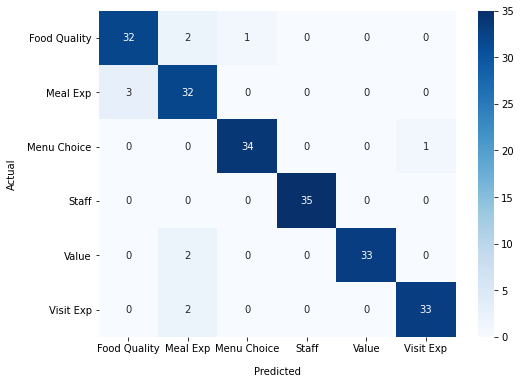

In [87]:
prediction(clf4,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [88]:
modsvm2 = prediction.results
modsvm2

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.947619,0.949735,0.947619,0.948256,0.994367


## Attractions

### Multinomial NB

              precision    recall  f1-score   support

           0       0.70      0.93      0.80        30
           1       0.84      0.87      0.85        30
           2       1.00      0.67      0.80        15
           3       0.80      0.80      0.80        30
           4       0.84      0.80      0.82        20
           5       0.93      0.87      0.90        15
           6       0.76      0.64      0.70        25

    accuracy                           0.81       165
   macro avg       0.84      0.80      0.81       165
weighted avg       0.82      0.81      0.80       165



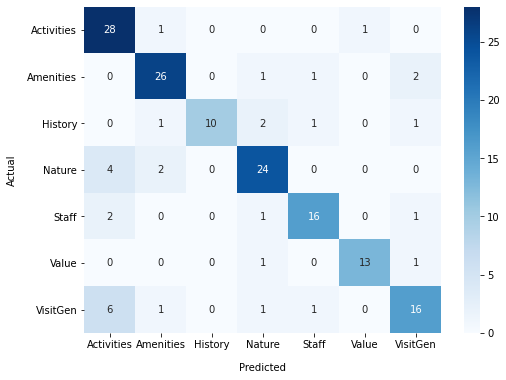

In [89]:
prediction(clf1,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [90]:
modnb3 = prediction.results
modnb3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.806061,0.818058,0.806061,0.804992,0.976545


### Logistic Regression

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.92      0.80      0.86        30
           2       1.00      0.80      0.89        15
           3       0.91      0.70      0.79        30
           4       0.89      0.80      0.84        20
           5       0.88      0.93      0.90        15
           6       0.56      0.96      0.71        25

    accuracy                           0.84       165
   macro avg       0.88      0.84      0.85       165
weighted avg       0.88      0.84      0.84       165



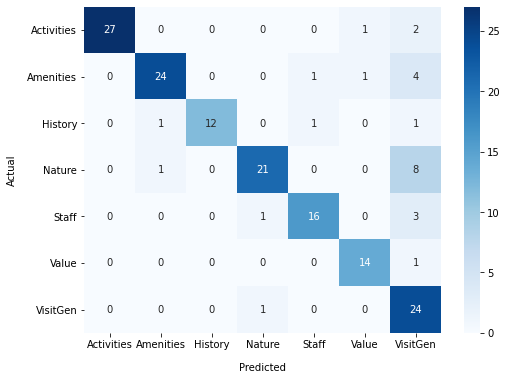

In [91]:
prediction(clf2,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [167]:
clf2.fit(X_train_attract_tfidf,y_train_attract_l)
filename = 'best_model_attract.sav'
joblib.dump(clf2, filename)

['best_model_attract.sav']

In [168]:
modlr3 = prediction.results
modlr3

,Accuracy,Precision,Recall,F1,ROCAUC
Attractions,0.836364,0.863515,0.836364,0.841142,0.978697


### Random Forest

              precision    recall  f1-score   support

           0       0.57      0.90      0.70        30
           1       0.88      0.73      0.80        30
           2       1.00      0.80      0.89        15
           3       0.95      0.70      0.81        30
           4       0.89      0.80      0.84        20
           5       0.88      1.00      0.94        15
           6       0.75      0.72      0.73        25

    accuracy                           0.79       165
   macro avg       0.85      0.81      0.82       165
weighted avg       0.83      0.79      0.80       165



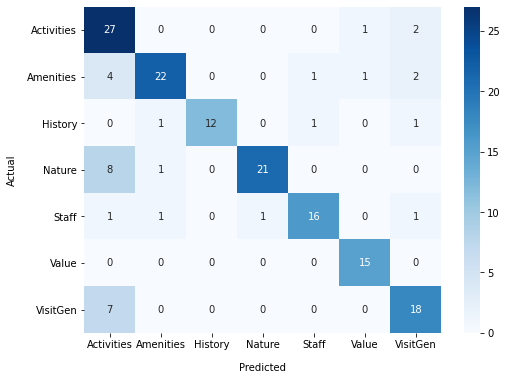

In [94]:
prediction(clf3,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [95]:
modrf3 = prediction.results
modrf3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.793939,0.830506,0.793939,0.799243,0.961193


### SVM

              precision    recall  f1-score   support

           0       0.74      0.93      0.82        30
           1       0.93      0.87      0.90        30
           2       1.00      0.87      0.93        15
           3       0.91      0.70      0.79        30
           4       0.93      0.65      0.76        20
           5       0.93      0.93      0.93        15
           6       0.56      0.76      0.64        25

    accuracy                           0.81       165
   macro avg       0.86      0.82      0.83       165
weighted avg       0.84      0.81      0.82       165



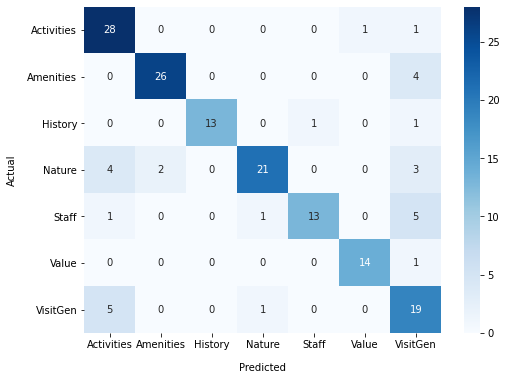

In [96]:
prediction(clf4,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [97]:
modsvm3 = prediction.results
modsvm3

,Accuracy,Precision,Recall,F1,ROCAUC
0,0.812121,0.841792,0.812121,0.816366,0.966052


# Section 5: Summary Tables

In [98]:
accom = pd.concat([modnb1,modlr1,modrf1,modsvm1])
accom.index = ["Accom NB","Accom LR","Accom RF","Accom SVM"]
accom.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Accom LR,0.918919,0.935106,0.918919,0.922196,0.995721
Accom NB,0.923423,0.926399,0.923423,0.924193,0.992637
Accom SVM,0.896396,0.912568,0.896396,0.899910,0.986667
Accom RF,0.918919,0.938965,0.918919,0.923921,0.979215


In [99]:
food = pd.concat([modnb2,modlr2,modrf2,modsvm2])
food.index = ["Food NB","Food LR","Food RF","Food SVM"]
food.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Food LR,0.942857,0.947872,0.942857,0.944112,0.996354
Food SVM,0.947619,0.949735,0.947619,0.948256,0.994367
Food RF,0.961905,0.965797,0.961905,0.962175,0.993646
Food NB,0.923810,0.925367,0.923810,0.922091,0.993551


In [100]:
attract = pd.concat([modnb3,modlr3,modrf3,modsvm3])
attract.index = ["Attract NB","Attract LR","Attract RF","Attract SVM"]
attract.sort_values(by = "ROCAUC",ascending = False)

,Accuracy,Precision,Recall,F1,ROCAUC
Attract LR,0.836364,0.878424,0.836364,0.844120,0.981034
Attract NB,0.806061,0.818058,0.806061,0.804992,0.976545
Attract SVM,0.812121,0.841792,0.812121,0.816366,0.966052
Attract RF,0.793939,0.830506,0.793939,0.799243,0.961193


# Section 6: Hyperparameter Tuning 

In [101]:
warnings.filterwarnings('ignore') 

In [135]:
best_model = LogisticRegression(class_weight = "balanced")
best_model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [136]:
parameters = {'C': [0.001,0.01,0.1,1,10,100], 'penalty': ['none', 'l1', 'l2', 'elasticnet'],'solver': ['newton-cg', 'lbfgs', 'sag','saga']}
clf = GridSearchCV(best_model,param_grid=parameters, cv = 10, scoring = 'roc_auc_ovr_weighted')

Note liblinear not supported with multinomial loss in multi-class problems

### Accommodation

In [137]:
clf.fit(X_train_accom_tfidf,y_train_accom)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='roc_auc_ovr_weighted')

In [138]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.9963403200470096
Best estimator: LogisticRegression(C=10, class_weight='balanced', solver='saga')




In [139]:
# Set up the best model
best_model_accom = LogisticRegression(class_weight = "balanced",C=10, penalty = 'l2', solver = 'saga')

              precision    recall  f1-score   support

           0       0.72      0.89      0.79        35
           1       0.97      0.94      0.96        35
           2       0.97      0.94      0.96        35
           3       1.00      0.91      0.95        22
           4       0.91      0.91      0.91        35
           5       0.97      0.89      0.93        35
           6       0.96      0.92      0.94        25

    accuracy                           0.91       222
   macro avg       0.93      0.91      0.92       222
weighted avg       0.92      0.91      0.92       222



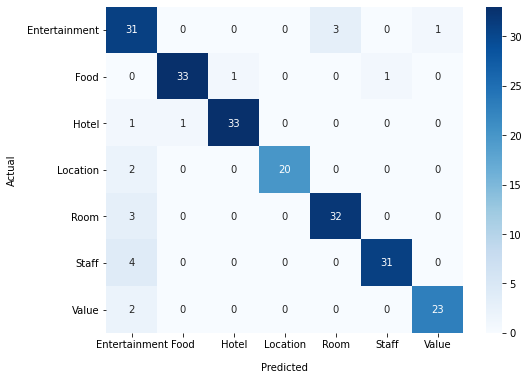

In [140]:
prediction(best_model_accom,X_train_accom_tfidf,y_train_accom_l,X_val_accom_tfidf,y_val_accom_l,labels_accom)

In [141]:
modlrah = prediction.results
modlrah.index = ["Accommodation"]
modlrah

,Accuracy,Precision,Recall,F1,ROCAUC
Accommodation,0.914414,0.923596,0.914414,0.917058,0.995764


In [175]:
# Save out for combined model
best_model_accom.fit(X_train_accom_tfidf,y_train_accom_l)
filename = 'best_model_accom.sav'
joblib.dump(best_model_accom, filename)

['best_model_accom.sav']

In [176]:
X_train_accom_tfidf

<1776x770 sparse matrix of type '<class 'numpy.float64'>'
	with 3574 stored elements in Compressed Sparse Row format>

### Food

In [142]:
clf.fit(X_train_food_tfidf, y_train_food)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='roc_auc_ovr_weighted')

In [143]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.9979251700680271
Best estimator: LogisticRegression(C=10, class_weight='balanced', solver='saga')




In [144]:
# Set up the best model
best_model_food = LogisticRegression(multi_class = 'multinomial', class_weight = "balanced",C=10, penalty = 'l2', solver = 'saga')

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        35
           1       0.84      0.91      0.88        35
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        35
           4       1.00      0.94      0.97        35
           5       1.00      0.94      0.97        35

    accuracy                           0.95       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.95      0.95      0.95       210



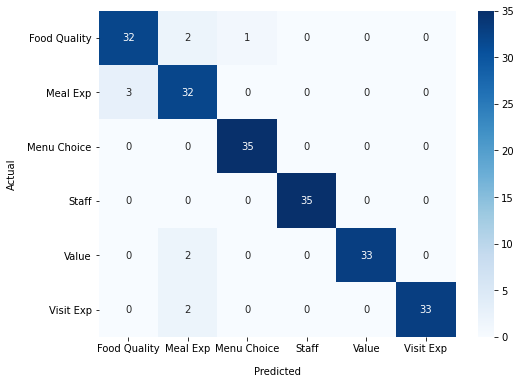

In [145]:
prediction(best_model_food,X_train_food_tfidf,y_train_food_l,X_val_food_tfidf,y_val_food_l,labels_food)

In [146]:
modlrfh = prediction.results
modlrfh.index = ["Food"]
modlrfh

,Accuracy,Precision,Recall,F1,ROCAUC
Food,0.952381,0.954769,0.952381,0.953015,0.996354


### Attractions

In [152]:
clf.fit(X_train_attract_tfidf, y_train_attract)

GridSearchCV(cv=10, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='roc_auc_ovr_weighted')

In [153]:
# Get results
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print(f'Best score: {results.best_score_}')
    print(f'Best estimator: {results.best_estimator_}')
    print("\n")
    
display(clf)

Best parameters are: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
Best score: 0.976010854301084
Best estimator: LogisticRegression(C=10, class_weight='balanced', solver='sag')




In [154]:
# Set up the best model
best_model_attract = LogisticRegression(multi_class = 'multinomial', class_weight = "balanced",C=10, penalty = 'l2', solver = 'sag')

              precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       0.89      0.83      0.86        30
           2       1.00      0.87      0.93        15
           3       0.88      0.70      0.78        30
           4       0.88      0.75      0.81        20
           5       0.88      0.93      0.90        15
           6       0.59      0.92      0.72        25

    accuracy                           0.84       165
   macro avg       0.87      0.84      0.85       165
weighted avg       0.86      0.84      0.84       165



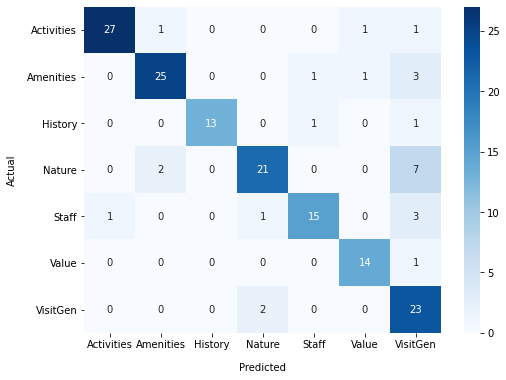

In [155]:
prediction(best_model_attract,X_train_attract_tfidf,y_train_attract_l,X_val_attract_tfidf,y_val_attract_l,labels_attract)

In [156]:
modlath = prediction.results
modlath.index = ["Attractions"]
modlath

,Accuracy,Precision,Recall,F1,ROCAUC
Attractions,0.836364,0.863515,0.836364,0.841142,0.978697
